<a href="https://colab.research.google.com/github/AjinJayan/weed_detection/blob/master/weed_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp /content/mrcnn/mask_rcnn_weed_0040.h5 "/content/drive/My Drive" # RUN ONLY WHEN YOU NEED TO SAVE WEIGHTS TO GOOGLE DRIVE

In [0]:
! pip install tensorflow==1.15

In [0]:
!pip install keras==2.1.0

In [0]:
! git clone https://github.com/matterport/Mask_RCNN.git    # mrcnn module inside Mask_RCNN directory 

In [0]:
! git clone https://github.com/AjinJayan/weed_detection.git    # contains dataset and weed.py.

In [0]:
!unzip -q '/content/weed_detection/dataset.zip'     # unzip the dataset

In [0]:
!python3 weed.py train --dataset=/content/dataset --weights=coco   # RUN TO TRAIN THE MODEL

Using TensorFlow backend.
Weights:  coco
Dataset:  /content/dataset
Logs:  /logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1

In [0]:
from google.colab import drive    # RUN WHEN TRAINED WEIGHTS GET UPLOADED TO THE GOOGLE DRIVE,  
drive.mount('/content/drive')     # so you can access files in google drive

In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import weed  # drag weed.py file outside from weed_detection directory 

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Weed trained weights, can be found in logs directory after TRAINING THE MODEL
# OR You will get already trained weights link in --trained_weights_Link file in https://github.com/AjinJayan/weed_detection.git 
#    download the weights from the link and upload to google drive 
BALLON_WEIGHTS_PATH = "/content/drive/My Drive/mask_rcnn_weed_0040.h5"  # TODO: update this path

Using TensorFlow backend.


In [0]:
config = weed.CustomConfig()
WEED_DIR = "/content/dataset"

In [7]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [10]:
# Load validation dataset
dataset = weed.CustomDataset()
dataset.load_custom(WEED_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 19
Classes: ['BG', 'weed']


In [11]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [12]:
# Set path to Weed weights file

# trained weights link in --trained_weights_Link file in https://github.com/AjinJayan/weed_detection.git 
# download the weights from the link and upload to google drive 
# weights_path = "/path/to/mask_rcnn_weed.h5"

# Or, load the last model you trained
weights_path = "/content/drive/My Drive/mask_rcnn_weed_0040.h5"

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/My Drive/mask_rcnn_weed_0040.h5








image ID: weed.185.jpg (2) /content/dataset/val/185.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (7,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (7, 4)                min:  130.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


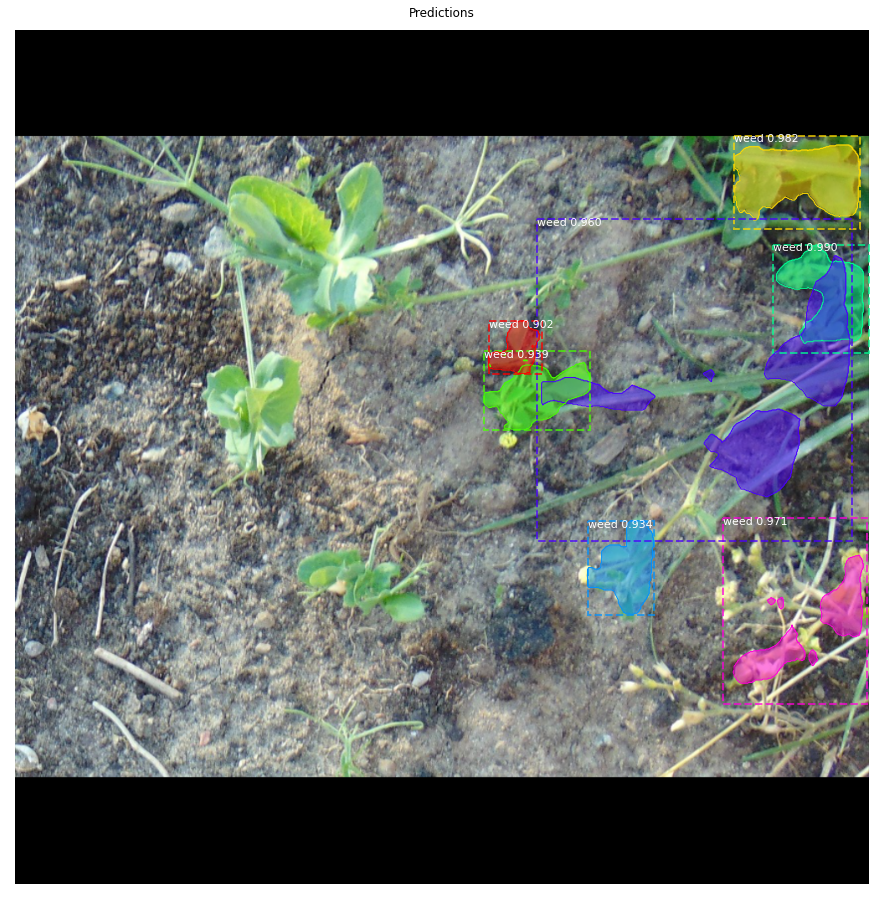

In [13]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

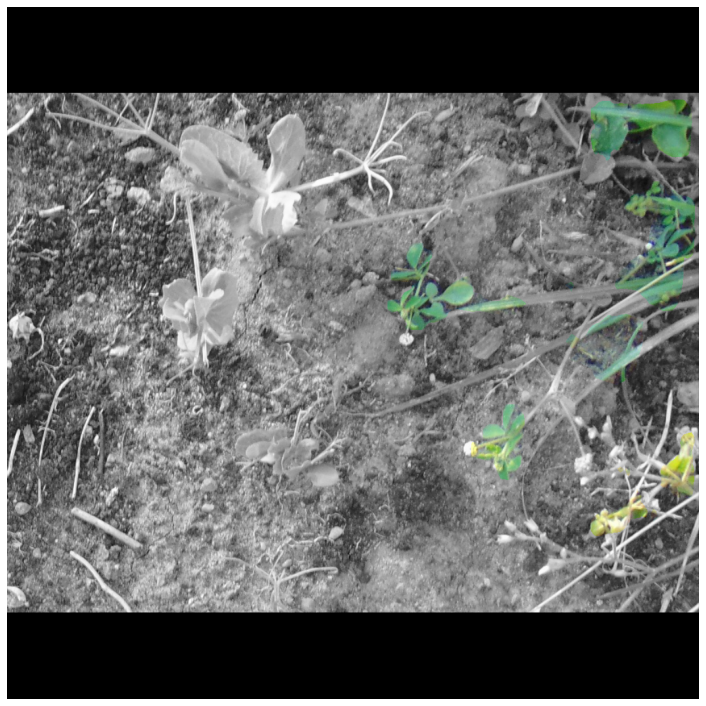

In [14]:
splash = weed.color_splash(image, r['masks'])
display_images([splash], cols=1)